(1618, 10)


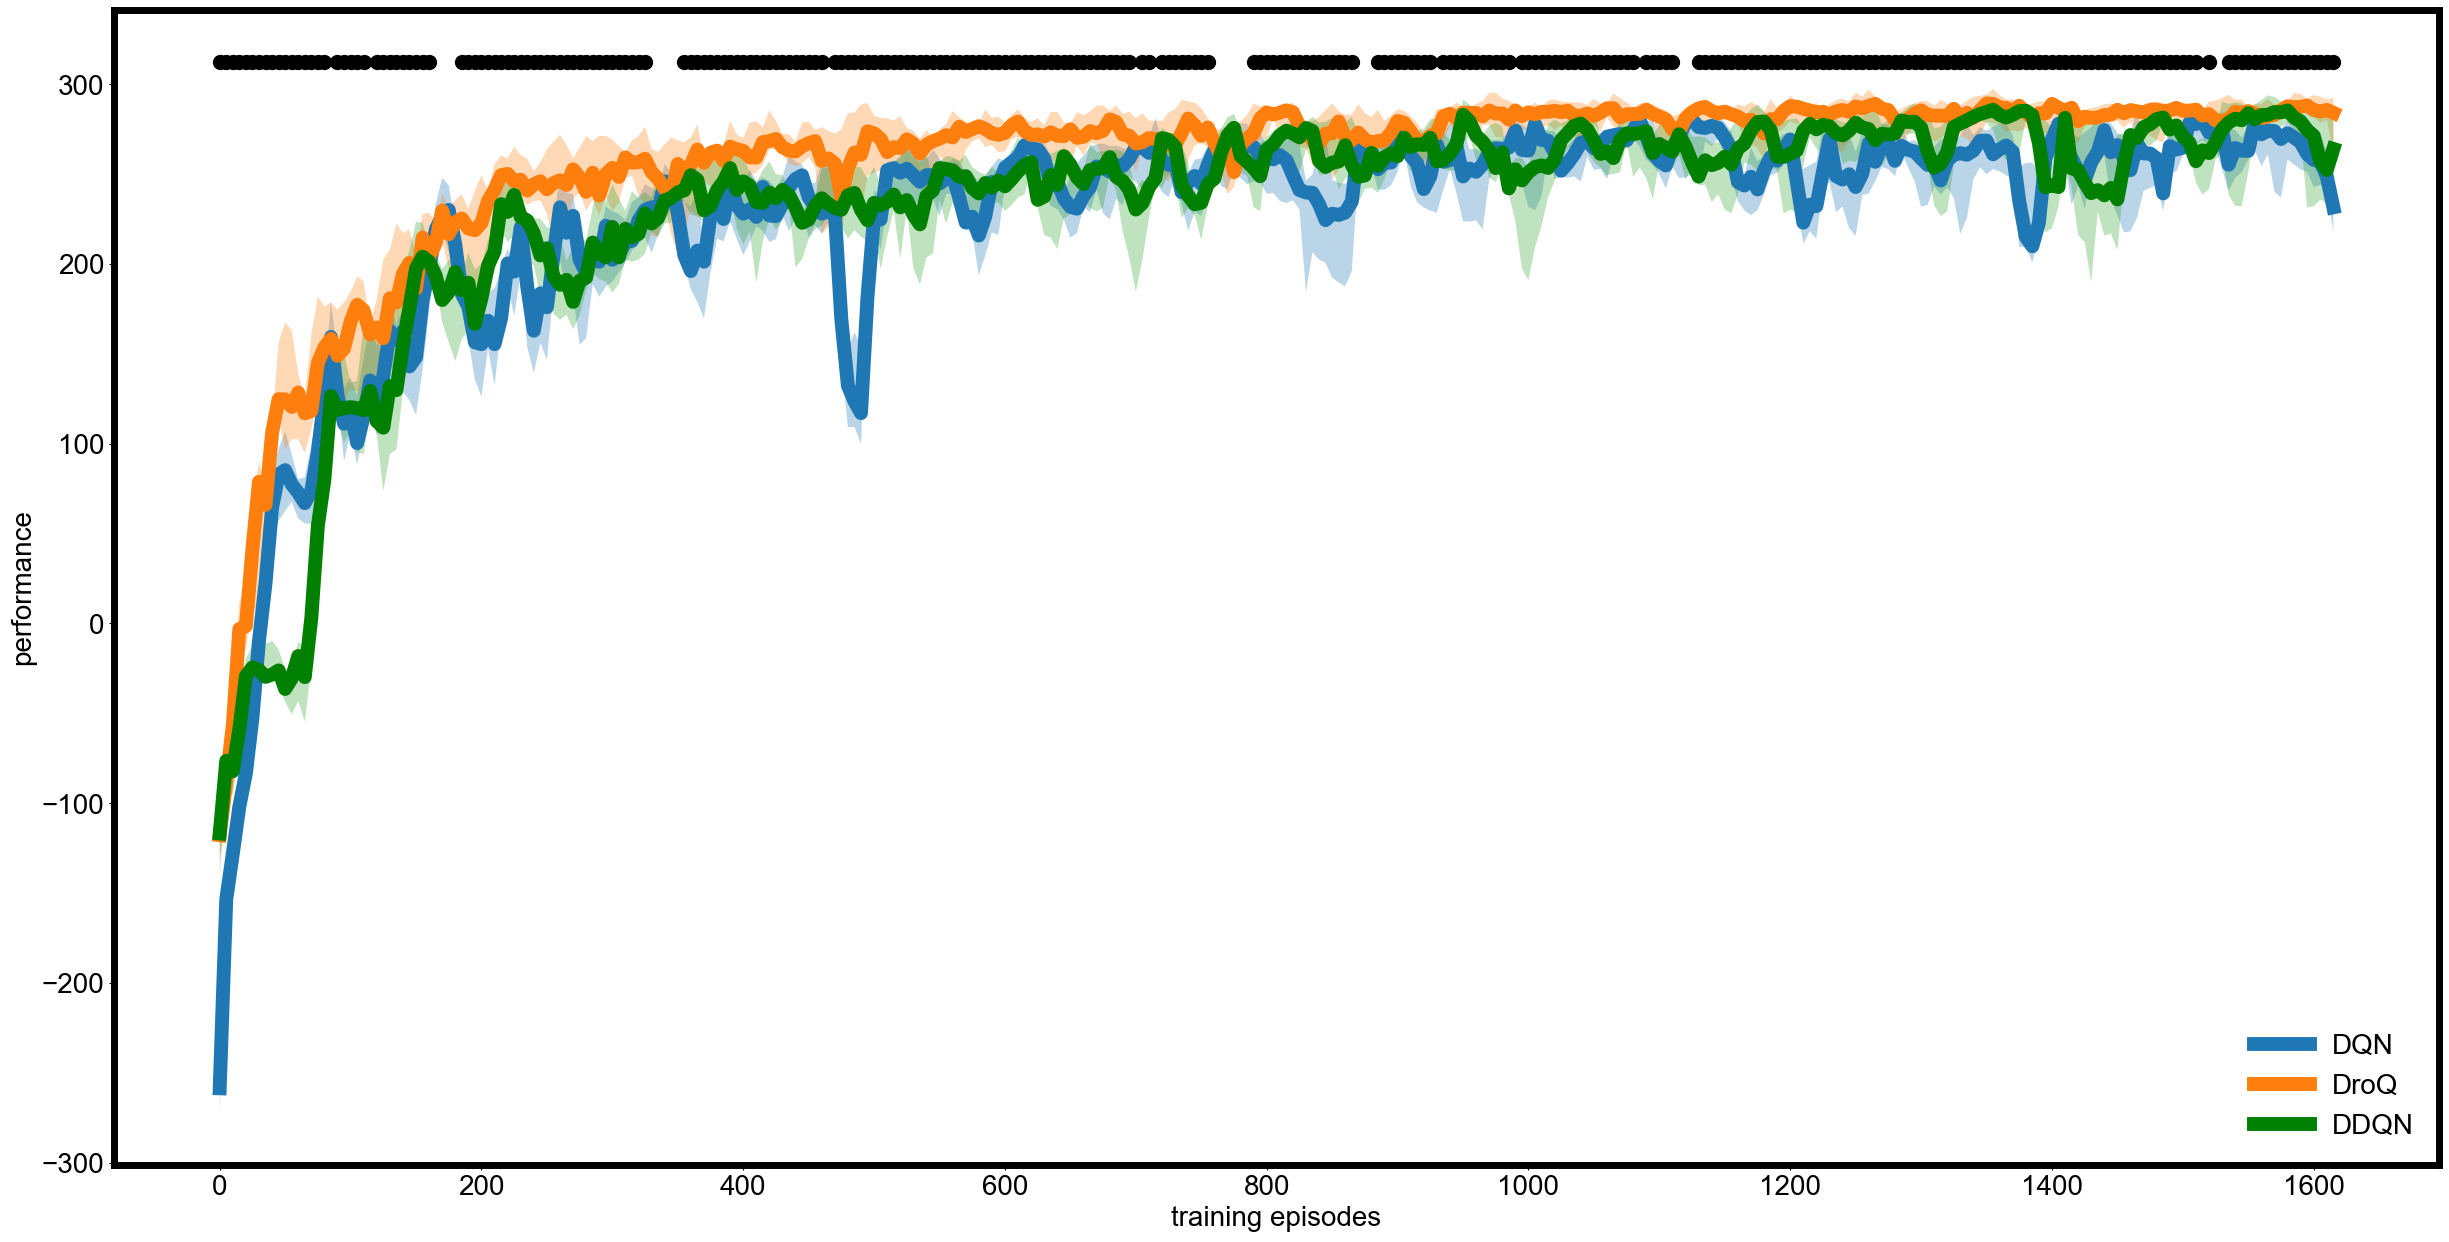

In [35]:
"""
In this script we show how to test and plot RL results.

"""
import sys

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from bbrl_algos.rliable_stats.tests import run_test

font = {"family": "arial", "size": 20}
matplotlib.rc("font", **font)
sys.path.append("../")


save = False  # save in ./plot.png if True

dqn_perfs = np.loadtxt("bbrl_algos/rliable_stats/data_files/dqn_RB_LunarLander-v2_1.data").T

# Make a moving average of dqn_perfs
dqn_perfs = np.array([np.mean(dqn_perfs[i:i+20, :], axis=0) for i in range(dqn_perfs.shape[0]-20)])

ddqn_perfs = np.loadtxt("bbrl_algos/rliable_stats/data_files/ddqn_RB_LunarLander-v2_1.data").T

# Make a moving average of ddqn_perfs
ddqn_perfs = np.array([np.mean(ddqn_perfs[i:i+20, :], axis=0) for i in range(ddqn_perfs.shape[0]-20)])

droQ_perfs = np.loadtxt("bbrl_algos/rliable_stats/data_files/droQ_RB_LunarLander-v2_1.data").T

# Make a moving average of droQ_perfs
droQ_perfs = np.array([np.mean(droQ_perfs[i:i+20, :], axis=0) for i in range(droQ_perfs.shape[0]-20)])

nb_datapoints = dqn_perfs.shape[1]
nb_steps = dqn_perfs.shape[0]

# Replace values bellow -800 by -800
dqn_perfs[dqn_perfs < -500] = -500
droQ_perfs[droQ_perfs < -500] = -500
ddqn_perfs[ddqn_perfs < -500] = -500

legend = ["DQN", "DroQ", "DDQN"]

# what do you want to plot ?
id_central = "median"  # 'mean'
id_error = 80  # (percentiles), also: 'std', 'sem'

# which test ?
# possible : ['t-test', "Welch t-test", 'Mann-Whitney', 'Ranked t-test', 'bootstrap', 'permutation']
test_id = "Welch t-test"  # recommended
confidence_level = 0.01

sample_size = 20
sample1 = dqn_perfs[:, np.random.randint(0, nb_datapoints, sample_size)]
sample2 = droQ_perfs[:, np.random.randint(0, nb_datapoints, sample_size)]
sample3 = ddqn_perfs[:, np.random.randint(0, nb_datapoints, sample_size)]

# downsample for visualization purpose
downsampling_fact = 5
steps = np.arange(0, nb_steps, downsampling_fact)
sample1 = sample1[steps, :]
sample2 = sample2[steps, :]
sample3 = sample3[steps, :]

# test
sign_diff = np.zeros([len(steps)])
for i in range(len(steps)):
    sign_diff[i] = run_test(
        test_id, sample1[i, :], sample2[i, :], alpha=confidence_level
    )


def compute_central_tendency_and_error(id_central, id_error, sample):
    if id_central == "mean":
        central = np.nanmean(sample, axis=1)
    elif id_central == "median":
        central = np.nanmedian(sample, axis=1)
    else:
        raise NotImplementedError

    if isinstance(id_error, int):
        low = np.nanpercentile(sample, q=int((100 - id_error) / 2), axis=1)
        high = np.nanpercentile(sample, q=int(100 - (100 - id_error) / 2), axis=1)
    elif id_error == "std":
        low = central - np.nanstd(sample, axis=1)
        high = central + np.nanstd(sample, axis=1)
    elif id_error == "sem":
        low = central - np.nanstd(sample, axis=1) / np.sqrt(sample.shape[0])
        high = central + np.nanstd(sample, axis=1) / np.sqrt(sample.shape[0])
    else:
        raise NotImplementedError

    return central, low, high


central1, low1, high1 = compute_central_tendency_and_error(
    id_central, id_error, sample1
)
central2, low2, high2 = compute_central_tendency_and_error(
    id_central, id_error, sample2
)

central3, low3, high3 = compute_central_tendency_and_error(
    id_central, id_error, sample3
)

# plot
fig, ax = plt.subplots(1, 1, figsize=(30, 15))
lab1 = plt.xlabel("training episodes")
lab2 = plt.ylabel("performance")

print(dqn_perfs.shape)

plt.plot(steps, central1, linewidth=10)
plt.plot(steps, central2, linewidth=10)
plt.plot(steps, central3, linewidth=10, color="green")
plt.fill_between(steps, low1, high1, alpha=0.3)
plt.fill_between(steps, low2, high2, alpha=0.3)
plt.fill_between(steps, low3, high3, alpha=0.3)
leg = ax.legend(legend, frameon=False)

# plot significative difference as dots
idx = np.argwhere(sign_diff == 1)
y = max(np.nanmax(high1), np.nanmax(high2))
plt.scatter(steps[idx], y * 1.05 * np.ones([idx.size]), s=100, c="k", marker="o")


# style
for line in leg.get_lines():
    line.set_linewidth(10.0)
ax.spines["top"].set_linewidth(5)
ax.spines["right"].set_linewidth(5)
ax.spines["bottom"].set_linewidth(5)
ax.spines["left"].set_linewidth(5)

if save:
    plt.savefig(
        "./plot.png", bbox_extra_artists=(leg, lab1, lab2), bbox_inches="tight", dpi=100
    )

plt.show()